
Olly Johnson
Attachments
9:27 AM (3 hours ago)
to p.garland, me

from:	Olly Johnson <bristoliver@gmail.com>
to:	p.garland@soton.ac.uk,
dave.babbitt@gmail.com
date:	Apr 28, 2020, 9:27 AM
subject:	Updated version
mailed-by:	gmail.com
signed-by:	gmail.com
security:	 Standard encryption (TLS) Learn more
:	Important according to Google magic.
Dear both,

I think I am getting there with the text: I'm attaching the pdf as it stands.

There are obviousy lots of little things that need doing (things like your affiliations, polishing etc), but I think the main one right now is the graphs.

I think it would be good to have 2 each: one with regular density, one with the weighted density. I think it makes sense to make them look as similar as we can (i.e. prepared in the same package) if we can manage that.

A couple of technical issues;
- Dave's graphs needed a log-log scale to show the correlation well (because the density varied a lot). Patrick, can yours do that, or do we need to do it differently for the two continents? I argued in the article that we're tracking rate of exponential growth, so I think it makes sense for deaths to be on a log-scale at least.
- I think it's possible the base point is slightly different: one (Patrick) may be "first hitting 5 deaths total" and the other (Dave) may be "first hitting 5 deaths in a day". Again, I don't think it matters too much, but best to be clear.

I'm happy to keep working on results and conclusions section, but feel free to make edits of any bits you'd like to.

All the best,

Olly

In [2]:

%run ../../load_magic/storage.py
s = Storage()


----
## Create Density DataFrame

In [12]:

counties_df = s.load_object('counties_df')
state_groupby = counties_df.groupby('State_Name')
weighted_density_dict = {}
for state_name, state_df in state_groupby:
    state_population = state_df.Estimate_2019.sum()
    weighted_density = 0
    for row_index, row_series in state_df.iterrows():
        county_population = row_series.Estimate_2019
        county_area = row_series.Land_Area
        weighted_density += county_population**2/county_area
    weighted_density /= state_population
    weighted_density_dict[state_name] = weighted_density

In [13]:

states_stats_df = s.load_object('states_stats_df')
density_df = pd.DataFrame.from_dict(weighted_density_dict, orient='index', columns=['Weighted_Density'])
density_df = pd.concat([states_stats_df.State_Abbreviation, density_df], axis='columns')
density_df.set_index('State_Abbreviation', drop=True, inplace=True)

In [14]:

# This is the standard population density calculation
columns_list = ['State_Abbreviation', 'State_Population', 'Land_Area_sq_km']
df = states_stats_df[columns_list]
df.set_index('State_Abbreviation', drop=True, inplace=True)
density_series = df.apply(lambda row_series: row_series.State_Population / row_series.Land_Area_sq_km, axis='columns')
density_series.name = 'Standard_Population_Density'
density_df = pd.concat([density_df, density_series], axis='columns')
#density_series

In [15]:

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_deaths_series = pd.read_csv(url,
                                   usecols=['date', 'state', 'death'],
                                   parse_dates=['date'],
                                   index_col=['state', 'date'],
                                   squeeze=True).sort_index()
states_deaths_series.fillna(value=0, inplace=True)
states_deaths_series = states_deaths_series.map(lambda x: int(x))

In [16]:

import re
from datetime import timedelta

f_str = '{} hit {} deaths in a day on {}. 10 days later, on {}, {} had a death toll of {} in one day.'
rows_list = []
column_name = re.sub(' ', '_', 'first hitting 5 deaths in a day'.title())
for state_abbrev, deaths_series in states_deaths_series.groupby('state'):
    i = deaths_series.searchsorted(5, side='right', sorter=None)
    if i < len(deaths_series):
        death_count = deaths_series[i]
        index_tuple = deaths_series.index[i]
        hit_date = index_tuple[1]
        later_date = hit_date + timedelta(days=10)
        mask_series = (deaths_series.index.get_level_values('date') >= later_date)
        ds = deaths_series[mask_series]
        #print(state_abbrev, death_count, ds.shape[0])
        if ds.shape[0] > 0:
            later_count = ds.iloc[0]
            row_dict = {}
            row_dict['State_Abbreviation'] = state_abbrev
            row_dict['Later_Count_After_{}'.format(column_name)] = later_count
            rows_list.append(row_dict.copy())
            print(f_str.format(state_abbrev, death_count, hit_date.strftime('%B %d'),
                               later_date.strftime('%B %d'), state_abbrev, later_count))
density_df = pd.concat([density_df, pd.DataFrame(rows_list).set_index('State_Abbreviation', drop=True, inplace=False)], axis='columns')

AK hit 6 deaths in a day on April 05. 10 days later, on April 15, AK had a death toll of 9 in one day.
AL hit 6 deaths in a day on March 30. 10 days later, on April 09, AL had a death toll of 74 in one day.
AR hit 6 deaths in a day on March 29. 10 days later, on April 08, AR had a death toll of 18 in one day.
AZ hit 6 deaths in a day on March 25. 10 days later, on April 04, AZ had a death toll of 52 in one day.
CA hit 6 deaths in a day on March 16. 10 days later, on March 26, CA had a death toll of 65 in one day.
CO hit 6 deaths in a day on March 23. 10 days later, on April 02, CO had a death toll of 80 in one day.
CT hit 10 deaths in a day on March 23. 10 days later, on April 02, CT had a death toll of 112 in one day.
DC hit 9 deaths in a day on March 30. 10 days later, on April 09, DC had a death toll of 32 in one day.
DE hit 6 deaths in a day on March 29. 10 days later, on April 08, DE had a death toll of 16 in one day.
FL hit 6 deaths in a day on March 17. 10 days later, on March 2

In [40]:

import re
from datetime import timedelta

f_str = '{} hit {} cumulative deaths on {}. 10 days later, on {}, {} had a death toll of {} in one day.'
rows_list = []
column_name = re.sub(' ', '_', 'first hitting 5 deaths total'.title())
for state_abbrev, deaths_series in states_deaths_series.groupby('state'):
    cum_series = deaths_series.cumsum()
    i = cum_series.searchsorted(5, side='left', sorter=None)
    if i < cum_series.shape[0]:
        death_count = cum_series[i]
        index_tuple = cum_series.index[i]
        hit_date = index_tuple[1]
        later_date = hit_date + timedelta(days=10)
        mask_series = (deaths_series.index.get_level_values('date') >= later_date)
        ds = deaths_series[mask_series]
        if ds.shape[0] > 0:
            later_count = ds.iloc[0]
            row_dict = {}
            row_dict['State_Abbreviation'] = state_abbrev
            row_dict['Later_Count_After_{}'.format(column_name)] = later_count
            rows_list.append(row_dict.copy())
            print(f_str.format(state_abbrev, death_count, hit_date.strftime('%B %d'),
                               later_date.strftime('%B %d'), state_abbrev, later_count))
density_df = pd.concat([density_df, pd.DataFrame(rows_list).set_index('State_Abbreviation', drop=True, inplace=False)], axis='columns')

AK hit 5 cumulative deaths on March 28. 10 days later, on April 07, AK had a death toll of 6 in one day.
AL hit 7 cumulative deaths on March 28. 10 days later, on April 07, AL had a death toll of 56 in one day.
AR hit 5 cumulative deaths on March 26. 10 days later, on April 05, AR had a death toll of 16 in one day.
AZ hit 5 cumulative deaths on March 23. 10 days later, on April 02, AZ had a death toll of 32 in one day.
CA hit 8 cumulative deaths on March 13. 10 days later, on March 23, CA had a death toll of 27 in one day.
CO hit 6 cumulative deaths on March 18. 10 days later, on March 28, CO had a death toll of 31 in one day.
CT hit 8 cumulative deaths on March 21. 10 days later, on March 31, CT had a death toll of 69 in one day.
DC hit 5 cumulative deaths on March 23. 10 days later, on April 02, DC had a death toll of 12 in one day.
DE hit 6 cumulative deaths on March 28. 10 days later, on April 07, DE had a death toll of 16 in one day.
FL hit 6 cumulative deaths on March 13. 10 days

In [41]:

s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv


In [43]:

import numpy as np

density_df = s.load_object('density_df')
for column_name in density_df.columns:
    log_column_name = 'Log_{}'.format(column_name)
    density_df[log_column_name] = density_df[column_name].map(lambda x: np.log(x))
s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv


In [45]:

density_df.columns.tolist()

['Weighted_Density',
 'Standard_Population_Density',
 'Later_Count_After_First_Hitting_5_Deaths_In_A_Day',
 'Later_Count_After_First_Hitting_5_Deaths_Total',
 'Log_Weighted_Density',
 'Log_Standard_Population_Density',
 'Log_Later_Count_After_First_Hitting_5_Deaths_In_A_Day',
 'Log_Later_Count_After_First_Hitting_5_Deaths_Total']

In [50]:

from scipy.stats import pearsonr

# Get r squared value
qe_column = 'Log_Weighted_Density'
f_str = 'For the {} column, the coefficient of determination (with a p-value of {}) is {}.'
for qr_column in ['Log_Later_Count_After_First_Hitting_5_Deaths_In_A_Day', 'Log_Later_Count_After_First_Hitting_5_Deaths_Total']:
    columns_list = [qe_column, qr_column]
    df = density_df[columns_list].dropna(axis='index', how='any')
    pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    print(f_str.format(qr_column, pvalue_statement, coefficient_of_determination_statement))

For the Log_Later_Count_After_First_Hitting_5_Deaths_In_A_Day column, the coefficient of determination (with a p-value of <0.0001) is 0.46.
For the Log_Later_Count_After_First_Hitting_5_Deaths_Total column, the coefficient of determination (with a p-value of <0.0001) is 0.39.


In [51]:

import re
from datetime import timedelta

for i in range(1, 51):
    rows_list = []
    column_name = 'hitting{}'.format(i)
    for state_abbrev, deaths_series in states_deaths_series.groupby('state'):
        cum_series = deaths_series.cumsum()
        i = cum_series.searchsorted(i, side='left', sorter=None)
        if i < cum_series.shape[0]:
            death_count = cum_series[i]
            index_tuple = cum_series.index[i]
            hit_date = index_tuple[1]
            later_date = hit_date + timedelta(days=10)
            mask_series = (deaths_series.index.get_level_values('date') >= later_date)
            ds = deaths_series[mask_series]
            if ds.shape[0] > 0:
                later_count = ds.iloc[0]
                row_dict = {}
                row_dict['State_Abbreviation'] = state_abbrev
                row_dict['{}'.format(column_name)] = later_count
                rows_list.append(row_dict.copy())
    density_df = pd.concat([density_df, pd.DataFrame(rows_list).set_index('State_Abbreviation', drop=True, inplace=False)],
                           axis='columns')

In [52]:

for i in range(1, 51):
    column_name = 'hitting{}'.format(i)
    log_column_name = 'Log_{}'.format(column_name)
    density_df[log_column_name] = density_df[column_name].map(lambda x: np.log(x))

In [53]:

from scipy.stats import pearsonr

# Get r squared value
qe_column = 'Log_Weighted_Density'
rows_list = []
for i in range(1, 51):
    column_name = 'hitting{}'.format(i)
    qr_column = 'Log_{}'.format(column_name)
    columns_list = [qe_column, qr_column]
    df = density_df[columns_list].dropna(axis='index', how='any')
    pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
    pearson_r = pearsonr_tuple[0]
    coefficient_of_determination = pearson_r**2
    p_value = pearsonr_tuple[1]
    row_dict = {}
    row_dict['cumulative_deaths'] = i
    row_dict['coefficient_of_determination'] = coefficient_of_determination
    row_dict['p_value'] = p_value
    rows_list.append(row_dict.copy())
coefficients_df = pd.DataFrame(rows_list)
s.store_objects(coefficients_df=coefficients_df)
s.save_dataframes(include_index=True, coefficients_df=coefficients_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\coefficients_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\coefficients_df.csv


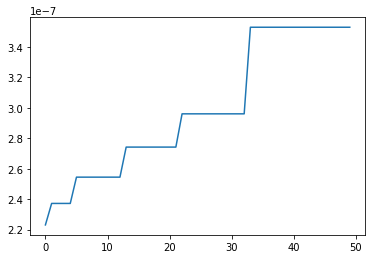

In [55]:

AxesSubplot_obj = coefficients_df.p_value.plot.line()

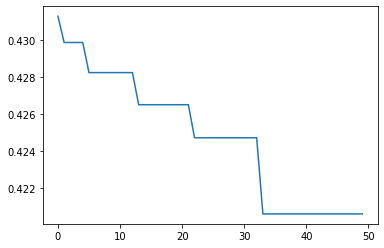

In [56]:

AxesSubplot_obj = coefficients_df.coefficient_of_determination.plot.line()

In [24]:

import pyperclip

pyperclip.copy(str(deaths_series.cumsum()))